In [65]:
%autosave 50000

Autosaving every 50000 seconds


In [66]:
import numpy as np
import pymc3 as pm 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
import os

sns.set_style("white")

font = { 'family' : 'normal',
         'weight' : 'normal',
        'size'    : 13}
plt.rc('font', **font)

In [67]:
from scipy import stats
from pymc3.distributions import draw_values
from pymc3.distributions import generate_samples
from pymc3.theanof import floatX
from pymc3.distributions.dist_math import bound
from pymc3.distributions import (Continuous, draw_values, generate_samples)

def assert_negative_support(var, label, distname, value=-1e-6):
    # Checks for evidence of positive support for a variable
    if var is None:
        return
    try:
        # Transformed distribution
        support = np.isfinite(var.transformed.distribution.dist
                              .logp(value).tag.test_value)
    except AttributeError:
        try:
            # Untransformed distribution
            support = np.isfinite(var.distribution.logp(value).tag.test_value)
        except AttributeError:
            # Otherwise no direct evidence of non-positive support
            support = False

    if np.any(support):
        msg = "The variable specified for {0} has negative support for {1}, ".format(
            label, distname)
        msg += "likely making it unsuitable for this parameter."
        warnings.warn(msg)

def get_tau_sigma(tau=None, sigma=None):
    if tau is None:
        if sigma is None:
            sigma = 1.
            tau = 1.
        else:
            tau = sigma**-2.
    else:
        if sigma is not None:
            raise ValueError("Can't pass both tau and sigma")
        else:
            sigma = tau**-.5
    tau = 1. * tau
    sigma = 1. * sigma
    return floatX(tau), floatX(sigma)



class weighted_Normal(pm.distributions.Continuous):

    def __init__(self, mu=0, sigma=None, tau=None, sd=None, weight =None,**kwargs):
        if sd is not None:
            sigma = sd
        tau, sigma = get_tau_sigma(tau=tau, sigma=sigma)
        self.sigma = self.sd = tt.as_tensor_variable(sigma)
        self.tau = tt.as_tensor_variable(tau)
        self.weight = tt.as_tensor_variable(weight)

        self.mean = self.median = self.mode = self.mu = mu = tt.as_tensor_variable(floatX(mu))
        self.variance = 1. / self.tau

        assert_negative_support(sigma, 'sigma', 'Normal')
        assert_negative_support(tau, 'tau', 'Normal')

        super().__init__(**kwargs)

    def random(self, point=None, size=None):
       
        mu, tau, _ = draw_values([self.mu, self.tau, self.sigma],
                                 point=point, size=size)
        return generate_samples(stats.norm.rvs, loc=mu, scale=tau**-0.5,
                                dist_shape=self.shape,
                                size=size)

    def logp(self, value):
        """
        Sum of Squares
       
        """
        sigma = self.sigma
        tau = self.tau
        mu = self.mu
        weight = self.weight
       
        logp = weight * - tt.sqr(value - mu)/(2.0 * sigma * sigma)
        return logp.sum()


In [68]:
# DATA 
cwd = os.getcwd()
os.chdir("/Users/danbarfod/Downloads")
dfx = pd.read_csv("jc_unmix_4_data_yz.csv")

In [69]:
# Part 1 ThermoCouple T Calibration 
## Step 1: Pyrometer Calibration
import os 
cwd = os.chdir('/Users/danbarfod/Downloads')
df1 = pd.read_csv("PyroApril2018.csv")
c1 = df1.iloc[:,0:1]
c2 = df1.iloc[:,1:2]
x1 = c1.values
x2 = c2.values
x1 = x1[x1 >=0]
x2 = x2[x2 >=0]
ThermoT = x2
PyroT = x1
zpt = np.polyfit(x1,x2,3)

In [70]:
# Ar39 
ar39 = dfx['Ar39_'].values
ar39 = ar39[~np.isnan(ar39)]

In [71]:
# Age 
age = dfx['Age'].values
age = age[~np.isnan(age)]
age_err = dfx['Age_Er'].values
age_err = age_err[~np.isnan(age_err)]
age_m = age
N = age.shape[0]

# Combined Plot Age Spectra + Cumulative Release 

# Arrhenius Plot

In [72]:

da2 = dfx['Da2'].values
da2_err = dfx['Da2_err'].values
da2_err = da2_err[~np.isnan(da2_err)]
temp1 = dfx['temp'].values
time = dfx['time'].values
da2_err
da2 = da2
temp = np.polyval(zpt, temp1)
tempk = temp + 273.15

tempk = tempk
tempk.shape[0]
da2 = da2

In [73]:
age = age
age_err = age_err
X = ar39
def frel(x): 
    y = np.cumsum(x)
    z = y/y.max()
    return z

fr1 = frel(X)
temp = temp


In [74]:
arr_data = np.log(da2)
tplot = 10000/(tempk)

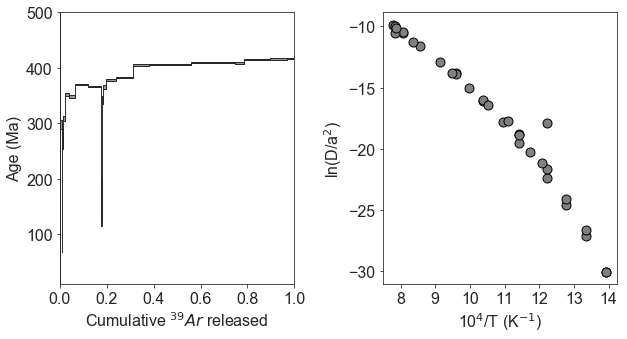

In [75]:
sns.set_style("white")

font = { 'family' : 'Arial',
         'weight' : 'normal',
        'size'    : 16}
plt.rc('font', **font)

import seaborn as sns
sns.set_style('ticks')
fig, ax = plt.subplots(1,2, figsize = (9,5))
ax[0].fill_between(fr1, age - age_err, age + age_err, 
                  step = 'pre', facecolor = 'grey', alpha = 0.8, 
                  edgecolor = 'k')
ax[0].set_xlabel('Cumulative $^{39}Ar$ released')
ax[0].set_ylabel('Age (Ma)')
ax[0].set_xlim(0, 1)
ax[0].set_ylim(200, 1000)


ax[1].plot(tplot[:len(arr_data)], arr_data, 
          'o', markerfacecolor = 'grey', 
          markeredgecolor = 'k', 
          markersize = 9)

ax[1].set_xlabel('10$^{4}$/T (K$^{-1}$)')
ax[1].set_ylabel('ln(D/a$^{2}$)')
ax[1].locator_params(axis='y', nbins=6)
ax[1].locator_params(axis='x', nbins=9)
#ax[1].set_xlim(5, 12)

ax[0].locator_params(axis='y', nbins=6)
ax[0].locator_params(axis='x', nbins=9)
ax[0].set_xlim(0, 1)
ax[0].set_ylim(10, 500)


plt.tight_layout()

In [76]:
from theano import shared
data = age_m
tempk = temp + 273.15
age_err_data = shared(age_err)
t_obs = time

In [77]:
N = data.shape[0]
arr_data = np.log(da2[:N])
data = age_m[:N]
t_obs = time[:N]
tempk = tempk[:N]
arr_err_data = shared(abs(da2_err[:N]/da2[:N]))

In [78]:
N

33

In [79]:
from theano import tensor as tt

def stick_break(beta): 
    
    X = tt.concatenate([[1], 
                       tt.extra_ops.cumprod(1 - beta)[:-1]])
    
    return beta * X

In [17]:
"""
Number of Components and Domains
Truncate point
"""
k = 20
m = 10
"""
Number of Data
"""
N = 33
"""
Open Model
"""
Q = pm.Model()
with Q: 
    """
    Number of Components
    """
    alpha = pm.Gamma('alpha', 1, 
                    1)
    
    beta = pm.Beta('beta', 1., alpha, 
                  shape = k,
                  testval = 0.9)
    
    K = pm.Deterministic('K', 
                        stick_break(beta))
    

    C = pm.Categorical('C', 
                      p = K, shape = (N,))
      
    """
    Number of Domains
    """
    phi = pm.Dirichlet('phi', a = np.ones(m), 
                      shape = (k,m))
    
    D = pm.Categorical('D', p = phi[C], 
                      shape = N)

In [18]:
with Q: 
        
    """
    Diffusion Kinetics
    """
    ea_mean = pm.Uniform('ea_mean', lower = 80, 
                            upper = 500,
                            shape = k,
                        testval = 200)
    
    ea_sd = pm.HalfNormal('ea_sd', 
                         sd = ea_mean/10, 
                         shape = k)
    
    Ea = pm.Normal('Ea', mu = ea_mean, 
                  sd = ea_sd, 
                  shape = k)

    
    d0_mean = pm.Uniform('d0_mean',
                    lower = 0.0, 
                    upper = 10000,
                    shape = k,
                        testval = 120)
    
    d0_sd = pm.HalfNormal('d0_sd', 
                         sd = d0_mean/10, 
                         shape = k)
    
    d0 = pm.Normal('d0', 
                  mu =d0_mean, 
                  sd = d0_sd, 
                  shape = k)
    
    pm.Potential('diff_kin_cons', 
                tt.switch(Ea < 80, -np.inf, 0) + 
                tt.switch(Ea > 500, -np.inf, 0)+ 
                 tt.switch(d0 < 0, -np.inf, 0)+
                 tt.switch(d0 > 10000, -np.inf, 0))
    

In [19]:
with Q: 
    """
    GSD/MDD
    """
    a = pm.Uniform('a', lower = 0.00001, 
                  upper = 0.025, 
                  shape = (k,m))
    

In [20]:
with Q: 
    """
    Age Prior
    """
    age_mean = pm.Uniform('age_mean', 
                         lower = 0.0, 
                         upper = 4600, 
                         shape = k,
                         testval = data.mean())
    
    age_sd = pm.HalfNormal('age_sd', 
                           sd = age_mean/20, 
                           shape = k)
    
    age_model =pm.Normal('age_model', 
                        mu = age_mean, 
                        sd = age_sd, 
                        shape = k)

    
    pm.Potential('age_con',
                tt.switch(age_model< 0, 
                         -np.inf, 0))

In [21]:
with Q: 
    """
    Indexing
    """
    age_comp = pm.Deterministic('age_comp',
                                age_model[C])
    
    ea_comp = pm.Deterministic('ea_comp',
                               Ea[C])
    
    d0_comp = pm.Deterministic('d0_comp',
                               d0[C])
    
    phi_comp = pm.Deterministic('phi_comp',
                                K[C])
    
    
    a_domain = pm.Deterministic("a_domain",
                                a[C,D])
    phi_domain = pm.Deterministic('phi_domain',
                                  phi[C,D])

/Applications/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


# Age Model

In [22]:
from numpy import pi
def inc_mdd(ea, d0, a,phi,temp, t):
    R = 8.314e-3
    D0t = ((phi/a)**2)* d0 * np.exp(-ea/(R*temp))*t
   
    q = (6./(np.pi**(3/2)))*np.sqrt((np.pi**2)*D0t)
   
    aa1 = np.sqrt(np.pi) * a**2 * R * temp**2
    bb1 = (phi/a)**2 * d0*np.exp(-ea/(R*temp))*t
    dd1 = 3 * d0 * ea * t * phi**2
    z1 = (dd1 * np.exp(-ea/(R*temp)))/(aa1 * np.sqrt(bb1))

    aa2 = a**2 * R *temp**2
    bb2 = (phi/a)**2 * d0*np.exp(-ea/(R*temp))*t
    cc1 = 3 * d0 * ea * t * phi**2 * np.exp(-ea/(R*temp))
    z2 = cc1/(np.sqrt(np.pi) * aa2 * np.sqrt(bb2)) - cc1/(aa2)
     
    aa3 = a**2 * R * temp**2
    bb3 = (phi/a)**2 * d0*np.exp(-ea/(R*temp))*t
    cc2 = 6 * d0 * ea * t * phi**2
    z3 = (cc2 * np.exp(-(pi**2 * bb3) - (ea/(R*temp)))/(aa3))

    Q = tt.switch(q <= 0.9,
                z2,
                 z3)
    T = tt.switch(q < 0.1, z1, Q)
    return T

In [23]:
with Q: 
    """
    Age Model
    """
    Y = inc_mdd(ea_comp, 
                d0_comp, 
                a_domain, 
                phi_domain,
                tempk[:,None],
                t_obs[:,None])
    
    inc_rel = (phi_comp * Y).sum(axis = 1) 
    
    XX = (Y * age_comp * phi_comp).sum(axis = 1)
    
    mu2 = (XX/inc_rel)
    

In [24]:
with Q: 
    
    """
    Incremental Release Trace
    """
    
    inc_rel = pm.Deterministic('inc_rel', inc_rel)

In [25]:
with Q:
    R = 8.314e-3
    yy2 =  (((phi[C,D]/a[C,D])**2) \
                 * d0[C] * np.exp(-Ea[C]/(R*tempk)))
    
    y2 = (K[C] * yy2)
    mu1 = tt.log(y2)

/Applications/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


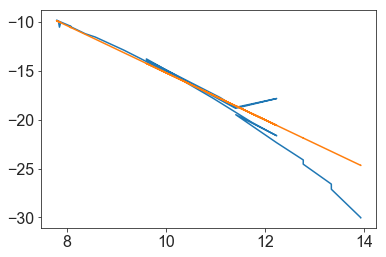

In [26]:
plt.plot(tplot[:N], np.log(da2[:N]))
plt.plot(tplot[:N], mu1.tag.test_value[:N])

# Likelihood Weights

In [27]:
"""
Calculate Model weights
"""

def logp_w(data, model, err):
    y = - ((data - model)**2/(2*err*err))
    return y.sum()



with Q: 

    y1 = logp_w(data[0:N], 
                mu2.tag.test_value[0:N], 
                age_err[0:N])
    
    y2 = logp_w(arr_data[0:N-1], 
                mu1.tag.test_value[0:N-1],
                arr_err_data[0:N-1])
    
    
    weight = y1/y2

In [28]:
weight.eval()

array(0.00017864)

In [29]:
1/weight.eval()

5597.719224254944

# Arrhenius Likelihood 

In [30]:
with Q: 
    obs1 = weighted_Normal('obs1', 
                    mu = mu1[0:N-1], 
                    sd = arr_err_data[0:N-1], 
                    observed = arr_data[0:N-1], 
                          weight = weight)

# Age Spectra Likelihood 

In [31]:
with Q: 
    obs2 = weighted_Normal('obs2', mu2[:N], age_err_data[:N], 
                         observed = data[:N], 
                          weight = 1) 

# Check Test Point Likelihood 
* Looking for negative infinities

In [32]:
Q.check_test_point()

/Applications/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Applications/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


alpha_log__               -1.00
beta_logodds__           -48.16
C                         -3.48
phi_stickbreaking__     -204.48
D                      -2507.52
ea_mean_interval__       -31.78
ea_sd_log__              -15.40
Ea                       -73.78
d0_mean_interval__       -88.70
d0_sd_log__              -15.40
d0                       -63.56
a_interval__            -277.26
age_mean_interval__      -53.73
age_sd_log__             -15.40
age_model                -70.42
obs1                  -18490.73
obs2                  -18490.73
Name: Log-probability of test_point, dtype: float64

In [33]:
SAMPLES = 100000
BURN = 1000000
SEED = np.random.seed(124)
with Q:
    step1 = pm.CategoricalGibbsMetropolis([C, D])
    
    
    step2 = pm.Metropolis([age_mean, 
                           age_sd, 
                           age_model,
                           ea_mean, ea_sd, Ea, 
                           d0_mean, d0_sd, d0,
                           a,
                           phi,
                           alpha, beta],
                           scaling = 100)
        
    
    
    trace = pm.sample(SAMPLES, tune = BURN, 
                     step = [step1,
                             step2], 
                     random_seed = SEED,
                     cores = 5)

Multiprocess sampling (5 chains in 5 jobs)
CompoundStep
>CategoricalGibbsMetropolis: [D, C]
>CompoundStep
>>Metropolis: [beta]
>>Metropolis: [alpha]
>>Metropolis: [phi]
>>Metropolis: [a]
>>Metropolis: [d0]
>>Metropolis: [d0_sd]
>>Metropolis: [d0_mean]
>>Metropolis: [Ea]
>>Metropolis: [ea_sd]
>>Metropolis: [ea_mean]
>>Metropolis: [age_model]
>>Metropolis: [age_sd]
>>Metropolis: [age_mean]
/Applications/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Sampling 5 chains: 100%|██████████| 5500000/5500000 [21:22:33<00:00, 23.17draws/s]    
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of e

Text(0, 0.5, 'Log probability')

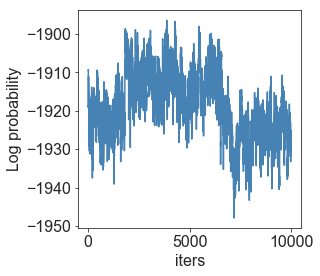

In [34]:
SAMPLES = 10000
logp_model = Q.logp

logp = [logp_model(i) for i in trace[-SAMPLES:]]
logp_x = np.array([logp])
logp_x = logp_x.reshape(SAMPLES)

plt.figure(figsize = (4,4))
plt.plot(logp_x,
        color = 'steelblue')
plt.xlabel('iters')
plt.ylabel('Log probability')

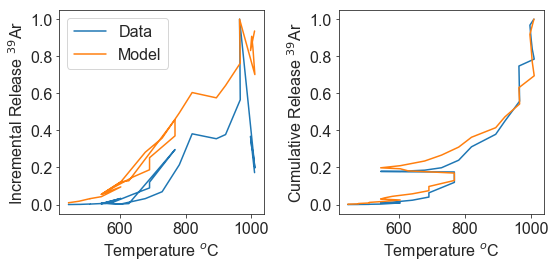

In [35]:
ar39 = dfx['Ar39_'].values

fig, ax = plt.subplots(1,2, figsize = (8,4))

ax[0].plot(temp[:N],
         ar39[:N]/ar39[:N].max(),
         label = 'Data')
ax[0].plot(temp[:N], 
         trace['inc_rel'].mean(axis = 0)/trace['inc_rel'].mean(axis = 0).max(),
          label= 'Model')



ax[1].plot(temp[:N], frel(ar39[:N]))
ax[1].plot(temp[:N], frel(trace['inc_rel'][-SAMPLES:].mean(axis = 0)))

ax[0].set_xlabel('Temperature $^{o}$C')
ax[1].set_xlabel('Temperature $^{o}$C')


ax[0].legend()
ax[0].set_ylabel('Incremental Release $^{39}$Ar')
ax[1].set_ylabel('Cumulative Release $^{39}$Ar')
plt.tight_layout()

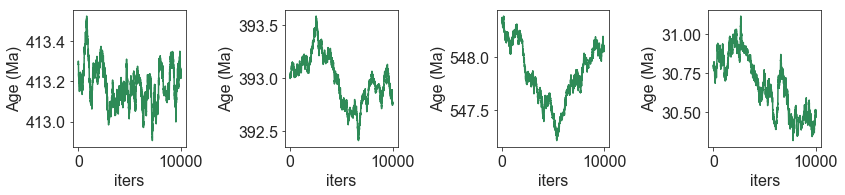

In [36]:
n_comp = np.apply_along_axis(lambda x: np.unique(x).size, 
                           1, trace['C'][-SAMPLES:])

n_comp = n_comp + 1
ncmp = n_comp.mean(axis = 0).astype(int)
plt.figure(figsize= (ncmp*3, ncmp*0.75))
for i in range(ncmp):
    plt.subplot(1, ncmp, i+1)
    plt.plot(trace['age_model'][-SAMPLES:][:,i],
            color= 'seagreen')
    plt.xlabel('iters')
    plt.ylabel('Age (Ma)')
    
plt.tight_layout()

### How Many Components?

In [37]:
SAMPLES = SAMPLES

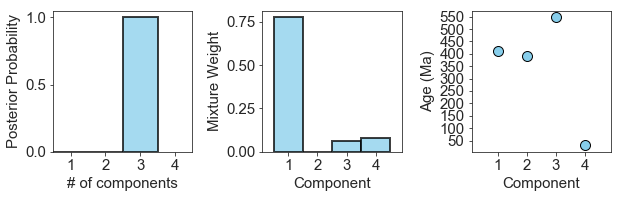

In [39]:
font = {'family' : 'Arial',
        'weight' : 'normal',
        'size'   : 15}

plt.rc('font', **font)

fig, ax = plt.subplots(1, 3, figsize = (9, 3))
n_comp = np.apply_along_axis(lambda x: np.unique(x).size, 
                            1, trace['C'][-SAMPLES:])

n_comp =  n_comp
ncmp = n_comp.mean(axis = 0).astype(int) + 1
bins = np.arange(n_comp.min() -2 , n_comp.max() + 2)

ax[0].hist(n_comp + 1,
        bins=bins,
        density=True,
        lw= 2,
        alpha=0.75, 
       edgecolor = 'k', 
        facecolor = 'skyblue');
ax[0].set_xticks(bins + 0.5);
ax[0].set_xticklabels(bins);
ax[0].set_xlim(bins.min(),bins.max() + 1);
ax[0].set_xlabel('# of components');
ax[0].set_ylabel('Posterior Probability')


plot_w = np.arange(ncmp) + 1
ax[1].bar(plot_w, trace['K'][-SAMPLES:].mean(axis=0)[:ncmp],
          width=1., lw=2, 
      edgecolor = 'k', alpha = 0.75, 
         facecolor = 'skyblue')

ax[1].set_xlabel('Component');
ax[1].set_ylabel('Mixture Weight');

ax[2].errorbar(np.linspace(1, ncmp, ncmp).astype(int),
             trace['age_model'][-SAMPLES:].mean(axis = 0)[:ncmp], 
             yerr = 2*trace['age_model'][-SAMPLES:].std(axis = 0)[:ncmp], 
             fmt ='o', 
             markersize = 10, 
             markeredgecolor = 'k', 
             markerfacecolor = 'skyblue')

ax[2].set_xlabel('Component');
ax[2].set_ylabel('Age (Ma)');

"""
Plotting layouts
"""
ax[2].locator_params(axis='x', nbins=ncmp + 1)
ax[1].locator_params(axis='x', nbins=ncmp + 1)
ax[2].locator_params(axis='y', nbins=12)
ax[2].set_xlim(0.1, ncmp +0.9)
ax[1].set_xlim(0.1, ncmp +0.9)

plt.tight_layout()
plt.savefig('bm4_nmcp.pdf')

In [40]:
np.set_printoptions(suppress=True)
trace['age_model'][-SAMPLES:].mean(axis = 0 )

array([ 413.17943293,  392.98507975,  547.84093587,   30.67663122,
        158.94997849,  291.1664661 ,    0.85356657,  532.15705574,
        267.55727894,   69.6082092 ,  757.69651679, 1163.66679644,
        409.29668175,  163.57300862,  366.6392374 ,  605.6956918 ,
        383.55590848,  518.730412  ,  279.24966833,  132.65550276])

In [41]:
trace['age_model'][-SAMPLES:].std(axis = 0 )

array([0.09594409, 0.2237884 , 0.27618216, 0.18778956, 0.32969522,
       0.26017131, 0.08085591, 0.24764839, 0.19839373, 0.17868293,
       0.38232608, 0.16263277, 0.21471867, 0.31261193, 0.17900222,
       0.51596992, 0.32899149, 0.25674036, 0.21850777, 0.14820073])

In [42]:
 trace['Ea'][-SAMPLES:].mean(axis = 0)

array([198.02079236, 213.32605632, 206.48265867, 212.02298433,
       177.20355162, 179.89057404, 198.77651523, 202.24170316,
       232.67551405, 188.17127727, 190.0009455 , 218.65800362,
       222.82444239, 158.70470967, 190.10208288, 204.79875838,
       197.59473296, 203.71162642, 209.70248237, 174.20607433])

# Posterior Predictive Model 

In [43]:
from scipy import stats
with Q: 
    ppc = pm.sample_ppc(trace[-10000:], 1000)

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: sample_ppc() is deprecated.  Please use sample_posterior_predictive()
  This is separate from the ipykernel package so we can avoid doing imports until
  0%|          | 0/1000 [00:00<?, ?it/s]/Applications/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Applications/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will res

In [80]:
# Mean Predictive Models
Z2 = ppc['obs2'].mean(axis = 0)
low2, high2 = np.percentile(ppc['obs2'], [50 - 34, 50 + 34], axis = 0)

Z1 = ppc['obs1'].mean(axis = 0)
low1, high1 = np.percentile(ppc['obs1'], [50 - 34, 50 + 34], axis = 0)
# Frel_model
inc_model = trace['inc_rel'].mean(axis = 0)
frel_model = frel(inc_model)



In [81]:
font = {'family' : 'Arial',
        'weight' : 'normal',
        'size'   : 8.5}

plt.rc('font', **font)
sns.set_style('ticks')

fr1 = frel(ar39[:-1])
age = age[:-1]
age_err = age_err[:-1]
# Plotting parameters 

low2_plot = np.insert(low2, 0, low2[0])
high2_plot = np.insert(high2, 0, high2[0])
z2_plot = np.insert(Z2, 0, Z2[0])
frel_model_plot = np.insert(frel_model, 0, 0)

data2_plot = np.insert(fr1, 0, 0)
data_plot = np.insert(age, 0, age[0])
age_err_plot = np.insert(age_err, 0, age_err[0])

# Age Spectra

(10, 800)

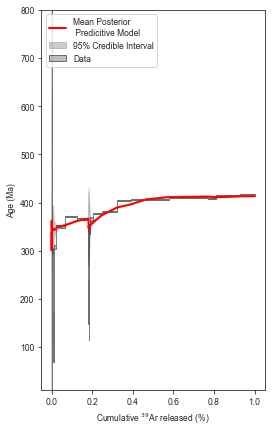

In [83]:

fig = plt.figure(figsize = (4, 7))

plt.fill_between(data2_plot[:N], low2_plot[:N], 
                 high2_plot[:N], 
                 alpha = 0.4, 
                color = 'grey', 
                label = '95% Credible Interval')
plt.plot(data2_plot[:N], z2_plot[:N], 'r', 
        lw = 2, 
        label = 'Mean Posterior \n Predicitive Model')
plt.fill_between(data2_plot[:N],
                 data_plot[:N] - age_err_plot[:N], 
                 data_plot[:N] + age_err_plot[:N], 
                step ='pre', 
                facecolor = 'grey', 
                alpha = 0.5, 
                edgecolor = 'k', 
                label = 'Data')

plt.xlabel('Cumulative $^{39}$Ar released (%)')
plt.ylabel('Age (Ma)')
plt.legend(loc = 2)

plt.ylim(10, 800)


/Applications/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


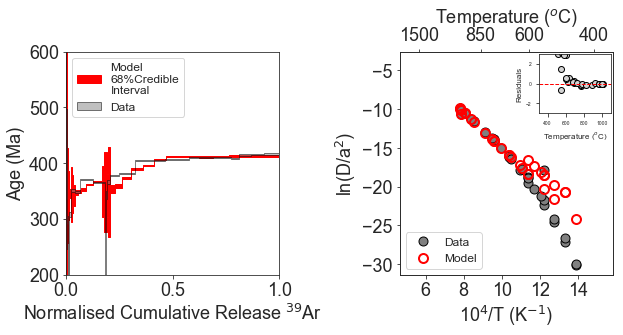

In [87]:
font= {"family": "Arial",
      "weight": "normal",
      "size":18}

plt.rc("font", **font)




fig, ax = plt.subplots(1,2, figsize = (9, 5))

ax[0].fill_between(frel_model_plot, low2_plot,
                 high2_plot,
                 alpha = 1,
                color = 'r',
                label = 'Model\n68%Credible\nInterval',
                  step = 'pre',
                  interpolate = True,  
                  lw = 1)


ax[0].fill_between(data2_plot[:N],
                 data_plot[:N] - age_err_plot[:N], 
                 data_plot[:N] + age_err_plot[:N], 
                step ='pre', 
                facecolor = 'grey', 
                alpha = 0.5, 
                edgecolor = 'k', 
                label = 'Data')
ax[0].set_xlabel('Cumulative $^{39}Ar$ released')
ax[0].set_ylabel('Age (Ma)')


ax[0].set_xlabel('Normalised Cumulative Release $^{39}$Ar')
ax[0].set_ylabel('Age (Ma)')




ax[1].plot(tplot[:N], arr_data[:N],
          'o', markerfacecolor = 'grey',
          markeredgecolor = 'k',
          markersize = 9, label = 'Data')


ax[1].plot(tplot[:N-1],Z1[:N], 'or',
             markerfacecolor = 'None',
            alpha = 1,
             markeredgecolor = 'r', markeredgewidth = 2,
            markersize = 9,
            label = 'Model')


#### Temp #####

ax2 = ax[1].twiny()

Tdc = np.array([400,  600, 850,  1500])
Tp = 10e3/(Tdc + 273.15)
labels = list(['400', '600', '850',  
              '1500'])
ax2.plot(tplot[:N], arr_data[:N], alpha = 0)
ax2.set_xlabel('Temperature ($^{o}$C)')
ax[1].set_xlim(Tp.min() - 1, Tp.max()+ 1)
ax2.set_xlim(Tp.min() -1, Tp.max()+ 1)

ax2.set_xlabel('Temperature ($^{o}$C)')
ax2.set_xticks(Tp)
ax2.set_xticklabels(labels)


ax3 =plt.axes([0.85,0.65,0.112,0.165])

ax3.plot(tempk[:N-1] - 273.15, Z1 - arr_data[:N-1], 'ok',
        markeredgecolor = 'k',
        markerfacecolor = 'lightgrey')

ax3.axhline(0, lw = 1, ls = '--',
           color = 'r')
ax3.set_ylabel('Residuals', fontsize = 8)
ax3.set_xlabel('Temperature ($^{o}$C)', fontsize = 8)
ax3.set_ylim(-3, 3)
ax3.tick_params(labelsize = 5)
ax3.locator_params(axis='x', nbins=6)
ax3.set_xlim(300, 1100)

ax[1].set_xlabel('10$^{4}$/T (K$^{-1}$)')
ax[1].set_ylabel('ln(D/a$^{2}$)')
ax[1].locator_params(axis='y', nbins=6)
ax[1].locator_params(axis='x', nbins=6)


ax[0].set_ylim(200, 600)
ax[0].set_xlim(0, 1)

ax[0].legend(loc = 2, fontsize = 12)
ax[1].legend(loc = 3, fontsize = 12)

plt.tight_layout()


In [88]:
SAMPLES = 50000

In [89]:
df_age = pd.DataFrame({"age_model": Z2, 
                      "age_model_low": low2,
                      "age_model_high": high2,
                      "frel_model": frel_model})

df_arr = pd.DataFrame({"arr_model":Z1,
                      "arr_model_low":low1,
                      "arr_model_high": high1})

df_age_comp = pd.DataFrame({"age1":trace['age_model'][:,0][-SAMPLES::10],
                           "age2":trace['age_model'][:,2][-SAMPLES::10],
                           "age3":trace['age_model'][:,3][-SAMPLES::10]})

df_w_comp = pd.DataFrame({"w1":trace['K'][:,0][-SAMPLES::10],
                         "w2":trace['K'][:,2][-SAMPLES::10],
                         "w3":trace['K'][:,3][-SAMPLES::10]})


df_ea = pd.DataFrame({"ea1":trace['Ea'][:,0][-SAMPLES::10],
                         "ea2":trace['Ea'][:,2][-SAMPLES::10],
                         "ea3":trace['Ea'][:,3][-SAMPLES::10]})

df_d0 = pd.DataFrame({"d01":trace['d0'][:,0][-SAMPLES::10],
                         "d02":trace['d0'][:,2][-SAMPLES::10],
                         "d03":trace['d0'][:,3][-SAMPLES::10]})

In [90]:
df_age.to_csv("bm4_age.csv")
df_arr.to_csv("bm4_arr.csv")
df_age_comp.to_csv("bm4_age_comp.csv")
df_w_comp.to_csv("bm4_w_comp.csv")


df_d0.to_csv("bm4_d0.csv")
df_ea.to_csv("bm4_ea.csv")